In [1]:
%load_ext autoreload
%autoreload 2

from ml4a import image
from ml4a.models import spade

print(spade.get_pretrained_models())

dict_keys(['cityscapes', 'ade20k', 'coco', 'landscapes'])


In [2]:
spade.load_model('landscapes')
print(spade.classes)

Network [SPADEGenerator] was created. Total number of parameters: 97.4 million. To see the architecture, do print(network).
{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'street sign', 12: 'stop sign', 13: 'parking meter', 14: 'bench', 15: 'bird', 16: 'cat', 17: 'dog', 18: 'horse', 19: 'sheep', 20: 'cow', 21: 'elephant', 22: 'bear', 23: 'zebra', 24: 'giraffe', 25: 'hat', 26: 'backpack', 27: 'umbrella', 28: 'shoe', 29: 'eye glasses', 30: 'handbag', 31: 'tie', 32: 'suitcase', 33: 'frisbee', 34: 'skis', 35: 'snowboard', 36: 'sports ball', 37: 'kite', 38: 'baseball bat', 39: 'baseball glove', 40: 'skateboard', 41: 'surfboard', 42: 'tennis racket', 43: 'bottle', 44: 'plate', 45: 'wine glass', 46: 'cup', 47: 'fork', 48: 'knife', 49: 'spoon', 50: 'bowl', 51: 'banana', 52: 'apple', 53: 'sandwich', 54: 'orange', 55: 'broccoli', 56: 'carrot', 57: 'hot dog', 58: 'pizza', 59: 'donut', 6

Pass the labels from `semantic_segmentation` to `SPADE`. Note the class labels are not identical, so some conversion is needed.

Loading weights for net_encoder
Loading weights for net_decoder


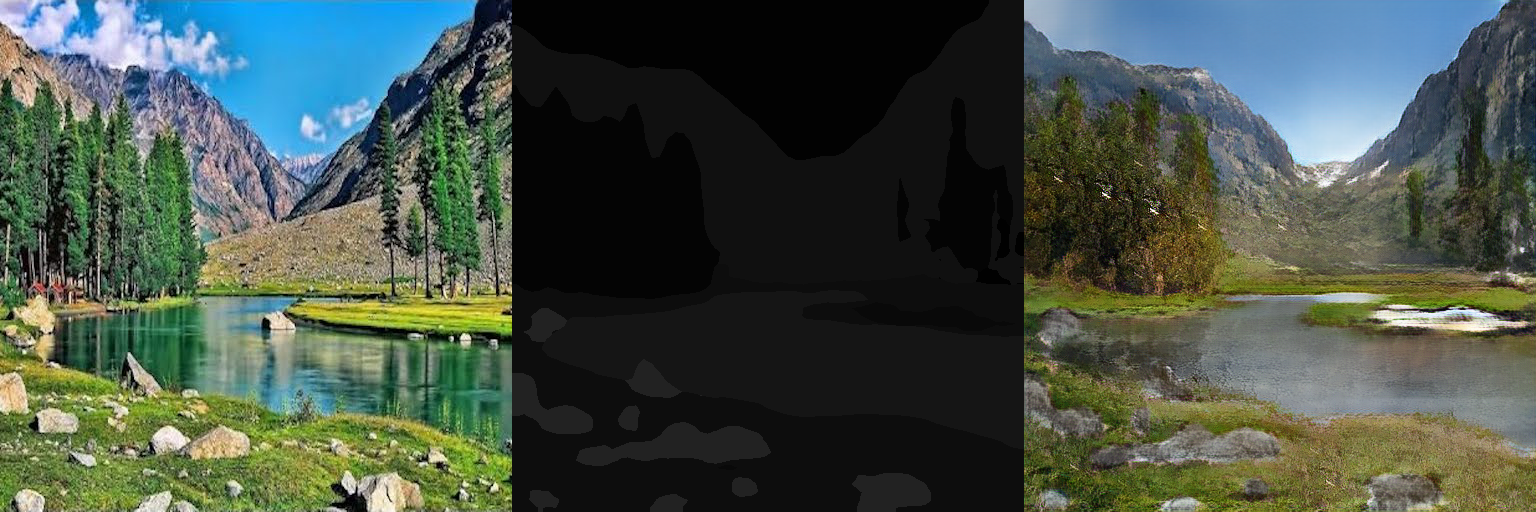

In [3]:
from ml4a.models import semantic_segmentation

img = image.load_image('https://github.com/abraham-ai/eden/raw/master/images/mountains.jpg', (512, 512))
labels = semantic_segmentation.run(img)
labels2 = labels.copy()

# convert labels between datasets (coco or landscapes)
labels2[labels == semantic_segmentation.get_class_index('mountain')] = spade.get_class_index('mountain')
labels2[labels == semantic_segmentation.get_class_index('earth')] = spade.get_class_index('grass')
labels2[labels == semantic_segmentation.get_class_index('water')] = spade.get_class_index('river')
labels2[labels == semantic_segmentation.get_class_index('tree')] = spade.get_class_index('tree')
labels2[labels == semantic_segmentation.get_class_index('sky')] = spade.get_class_index('sky-other')

# convert labels between datasets (ade20k)
# labels2[labels == semantic_segmentation.get_class_index('mountain')] = spade.get_class_index('building')
# labels2[labels == semantic_segmentation.get_class_index('earth')] = spade.get_class_index('sidewalk')
# labels2[labels == semantic_segmentation.get_class_index('water')] = spade.get_class_index('water')
# labels2[labels == semantic_segmentation.get_class_index('tree')] = spade.get_class_index('tree')
# labels2[labels == semantic_segmentation.get_class_index('sky')] = spade.get_class_index('sky')

# convert labels between datasets (cityscapes)
# labels2[labels == semantic_segmentation.get_class_index('mountain')] = spade.get_class_index('building')
# labels2[labels == semantic_segmentation.get_class_index('earth')] = spade.get_class_index('sidewalk')
# labels2[labels == semantic_segmentation.get_class_index('water')] = spade.get_class_index('road')
# labels2[labels == semantic_segmentation.get_class_index('tree')] = spade.get_class_index('vegetation')
# labels2[labels == semantic_segmentation.get_class_index('sky')] = spade.get_class_index('sky')


img2 = spade.run(labels2)

all_images = image.concatenate_images([img, labels, img2])
image.display(all_images)

In [19]:
labels2[labels == semantic_segmentation.get_class_index('water')]


In [14]:
semantic_segmentation.get_class_index('water')

21